# Evaluating the Performance of MiDaS on Drone Data
---

# 1. Gather Data

In [1]:
import os
import rosbag
import matplotlib.pyplot as plt
import numpy as np
import run
import pickle
import eval_utils as eval_utils

c:\Users\User\.conda\envs\midas-performance-py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here you can configure the script to work with your data.

In [12]:
bag_file_name = 'test3.bag'         # name of bag file inside folder "drone_data"
data_filename = 'data.pickle'


topic_cam1 = '/d455/infra1/image_rect_raw'
topic_cam2 = '/d455/infra2/image_rect_raw'
topic_depth = '/d455/depth/image_rect_raw'

cam1rgb_key = 'cam1'
cam2rgb_key = 'cam2'
camdepth_key = 'depth_rs'

# running MiDaS
input_path = 'input'
output_path = 'output'


# model_path = 'weights/dpt_large_384.pt'
# model_type = 'dpt_large_384'
model_path = 'weights/midas_v21_small_256.pt'
model_type = 'midas_v21_small_256'


'''------------------------------------------
        Parameters for MiDaS
------------------------------------------'''
optimize=False
side=False
height=None
square=False
grayscale=True # Realsense output is grayscale


# get the current test_run
test_run = eval_utils.check_bag_file(bag_file_name)

In this run of the script we are investigating bag-file 'test3'.
In case the analysis has already been performed and data has been saved, the saved data will be used to save computational time.


---
## 1.1 Gathering Drone Footage

In [4]:
# get image data from rosbag
image_data_infra1_np, image_data_infra2_np, height, width = eval_utils.get_image_data(bag_file_name,topic_cam1,topic_cam2)

# add data to pickle if not done already
eval_utils.update_data(cam1rgb_key, data_filename, test_run, model_type, image_data_infra1_np)
eval_utils.update_data(cam2rgb_key, data_filename, test_run, model_type, image_data_infra2_np)

The bags contain 843 and 840 frames for the given topics.
'Data' already contains data for 'test3'.
'Data' also already contains data for 'midas_v21_small_256'.
'data' saved.
'Data' already contains data for 'test3'.
'Data' also already contains data for 'midas_v21_small_256'.
'data' saved.


### Examples

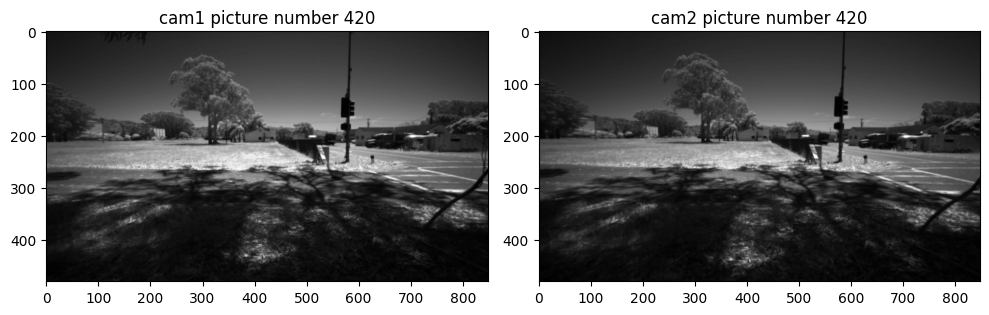

In [4]:
frame1 = 420
frame2 = 420

eval_utils.create_parallel_plots(frame1, frame2, cam1rgb_key, cam2rgb_key, data_filename, test_run, model_type)

---

## 1.2 Estimating Depth in Drone Footage

In [5]:
# run MiDaS on data from rosbag
run.run(data_filename, test_run, cam1rgb_key, output_path, model_path, model_type, optimize, side, height, square, grayscale)

# Load pickle file
data = eval_utils.load_pickle(data_filename)

Initialize
Device: cpu
Loading weights:  weights/midas_v21_small_256.pt


Using cache found in C:\Users\User/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


Model loaded, number of parameters = 21M
'data' loaded.
Start processing
Finished


### Examples

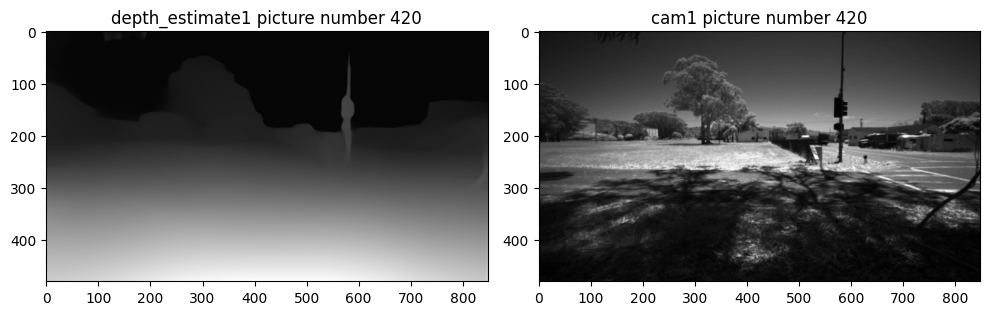

In [7]:
eval_utils.create_parallel_plots(frame1, frame2, 'depth_estimate1', cam1rgb_key, data_filename, test_run, model_type)

---
## 1.3 Getting "Real" Depth from Intel RealSense

In [8]:
depth_measurement_images = eval_utils.get_depth_data(bag_file_name,topic_depth)

# add data to pickle if not done already
eval_utils.update_data(camdepth_key, data_filename, test_run, model_type, depth_measurement_images)

'Data' already contains data for 'test3'.
'Data' also already contains data for 'midas_v21_small_256'.
'data' saved.


### Examples

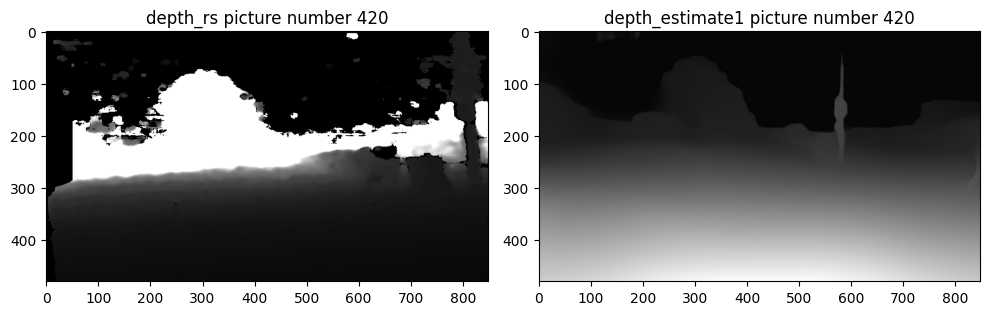

In [9]:
eval_utils.create_parallel_plots(frame1, frame2, camdepth_key,'depth_estimate1', data_filename, test_run, model_type)

Keep in mind that the index of the pictures does not necessarily indicate a correlation with the time they were taken.

---
# 2. Results

In [6]:
# Load pickle file
data = eval_utils.load_pickle(data_filename)

## 2.1 Image Differencing & Image Subtraction

* Image Differencing: two images must first be aligned so that corresponding points coincide
* Image Subtraction: digital numeric value of one pixel or whole image is subtracted from another image

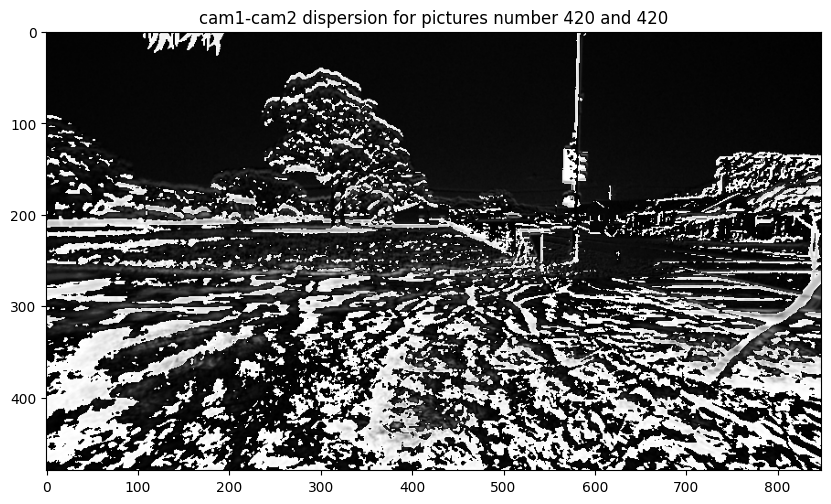

In [11]:
eval_utils.create_differencing_plot(frame1, frame2, data, cam1rgb_key, cam2rgb_key, test_run, model_type)

## 2.2 Comparing Depth-Estimation to "Ground Truth" from RealSense

In [9]:
# get max. depth in every depth-picture
max_measured_depth = []
for frame in data[test_run][model_type][camdepth_key]:
    max_measured_depth.append(frame.max())

# find depth-pictures in which max. depth is not 65535 = (2**16)-1
indices_not_max_depth = []      # (index_ value)
for i in range(len(max_measured_depth)):
    if max_measured_depth[i] != 65535:
        indices_not_max_depth.append((i, max_measured_depth[i]))

indices_not_max_depth

[(652, 49873), (653, 56379)]

In [10]:
eval_utils.get_closest_index(bag_file_name, topic_depth, 652, topic_cam1)

path:        drone_data\test3.bag
version:     2.0
duration:    57.4s
start:       Jun 26 2022 18:41:15.00 (1656261675.00)
end:         Jun 26 2022 18:42:12.45 (1656261732.45)
size:        2.5 GB
messages:    138880
compression: none [2860/2860 chunks]
types:       bond/Status                             [eacc84bf5d65b6777d4c50f463dfb9c8]
             diagnostic_msgs/DiagnosticArray         [60810da900de1dd6ddd437c3503511da]
             dynamic_reconfigure/Config              [958f16a05573709014982821e6822580]
             dynamic_reconfigure/ConfigDescription   [757ce9d44ba8ddd801bb30bc456f946f]
             geometry_msgs/PoseStamped               [d3812c3cbc69362b77dc0b19b345f8f5]
             geometry_msgs/PoseWithCovarianceStamped [953b798c0f514ff060a53a3498ce6246]
             geometry_msgs/TwistStamped              [98d34b0043a2093cf9d9345ab6eef12e]
             imgcomp_planner/drone_status            [b404e47c0e2d7928d00f6920d5f8af1b]
             imgcomp_planner/planner_diagno

739

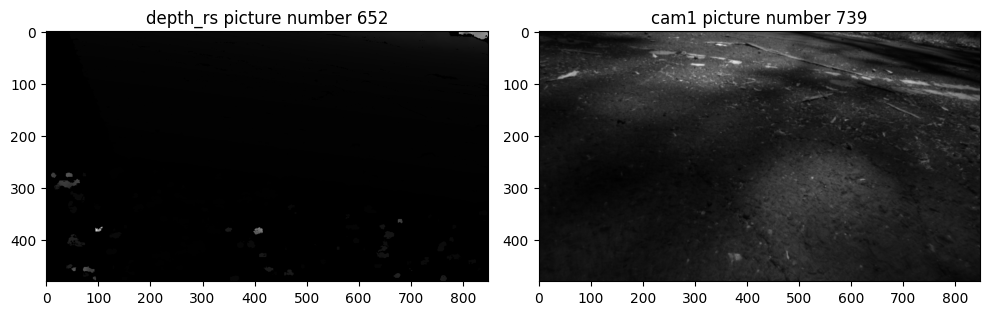

In [13]:
eval_utils.create_parallel_plots(652, 739, camdepth_key, cam1rgb_key, data_filename, test_run, model_type)

In [15]:
# get max. depth in every depth-picture
max_estimated_depth = []
for frame in data[test_run][model_type][cam1rgb_key]:
    max_estimated_depth.append(frame.max())

In [17]:
max_estimated_depth[739]

238

In [18]:
238/255

0.9333333333333333

In [20]:
56379/65535

0.8602883955138476

In [14]:
values_to_replace = [65535, 56379, 49873]

modified_list = []
for item in max_measured_depth:
    if item in values_to_replace:
        modified_list.append(0)
    else:
        modified_list.append(item)

In [15]:
max(modified_list)

0

In [16]:
# Values to check for equality
target_values = [56379, 49873]

# indices = [index for index, value in enumerate(max_measured_depth) if value in target_values]
# print(indices)  # Output: [1, 3, 5, 6]

indices = [index for index, value in enumerate(max_measured_depth) if value < max(max_measured_depth)]
print(indices)  # Output: [1, 3, 5, 6]

[652, 653]


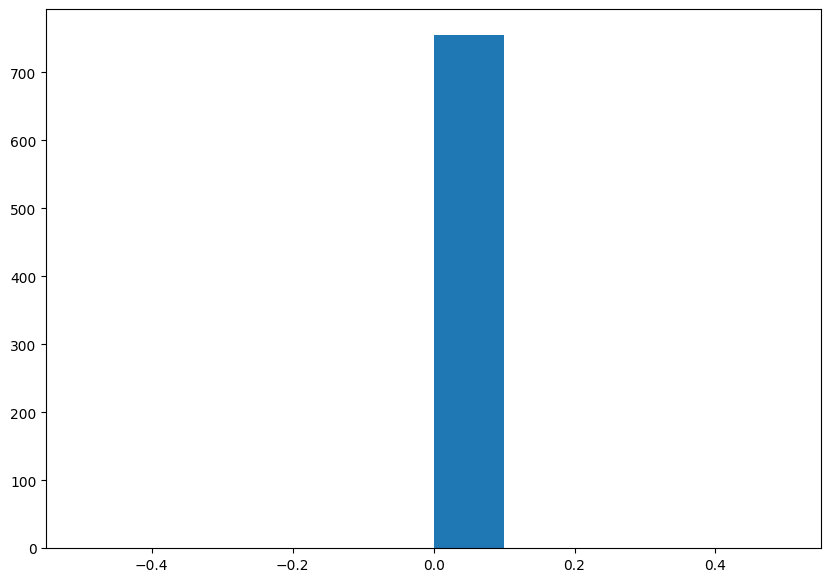

In [17]:
# max(max_measured_depth)

fig = plt.figure(figsize =(10, 7))

plt.hist(modified_list)

# max_error = difference_pic.max()
# min_error = difference_pic.min()
# text="Histogram of the error between depth estimation and measurement (Range: " + str(min_error) + "-" + str(max_error) + ")"

# plt.title(text)
plt.show()

In [18]:
'''
We have:
    - depth_estimate_images         [0-65534 or 65535] ?! TODO: check this
    - depth_measurement_images      [0-65535] in mm // TODO: Check if actually mm (could also be value set in camera-options)
'''
# max_depth = depth_measurement_images[idx_analysed_frame].max()
# difference_pic_zero = depth_estimate_images[idx_analysed_frame]/255 + depth_measurement_images[idx_analysed_frame]/max_depth

max_measured_depth = data[test_run][model_type]['depth_rs'][idx_analysed_frame].max()
print('Maximum measured depth: ' + str(max_measured_depth))

max_estimated1_depth = data[test_run][model_type]['depth_estimate1'][idx_analysed_frame].max()
# max_estimated2_depth = data[test_run][model_type]['depth_estimate1'][idx_analysed_frame].max()
print('Maximum estimated depth: ' + str(max_estimated1_depth))



difference_pic = data[test_run][model_type]['depth_estimate1'][idx_analysed_frame]/max_estimated1_depth + data[test_run][model_type]['depth_rs'][idx_analysed_frame]/max_measured_depth

difference_pic.max()

fig = plt.figure(figsize =(15, 15))
plt.imshow(difference_pic) # cmap='gray'
plt.show()

NameError: name 'idx_analysed_frame' is not defined

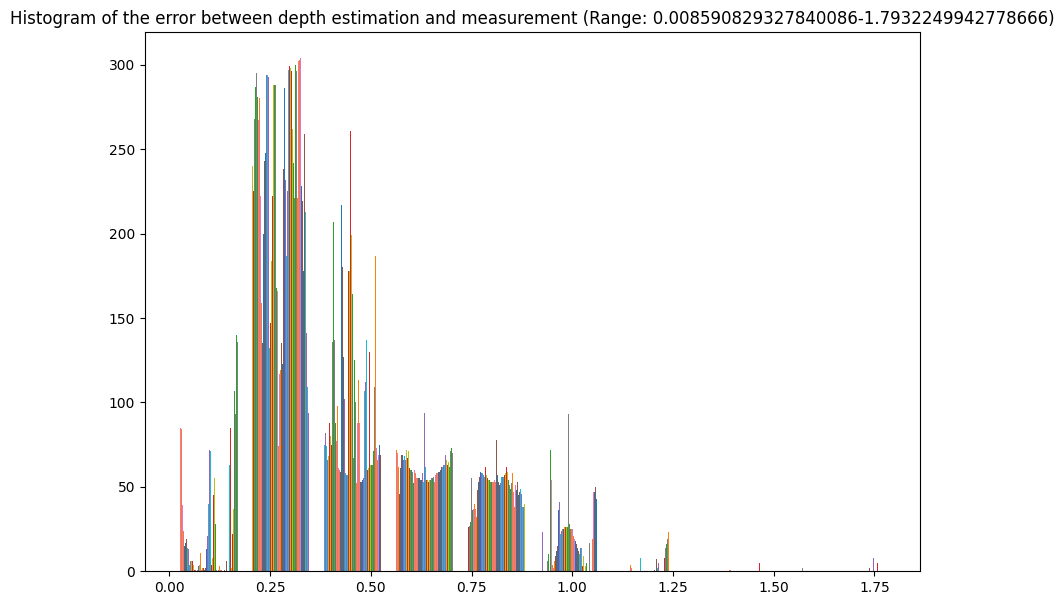

In [ ]:
fig = plt.figure(figsize =(10, 7))

plt.hist(difference_pic)   #, bins=10 

max_error = difference_pic.max()
min_error = difference_pic.min()
text="Histogram of the error between depth estimation and measurement (Range: " + str(min_error) + "-" + str(max_error) + ")"

plt.title(text)
plt.show()

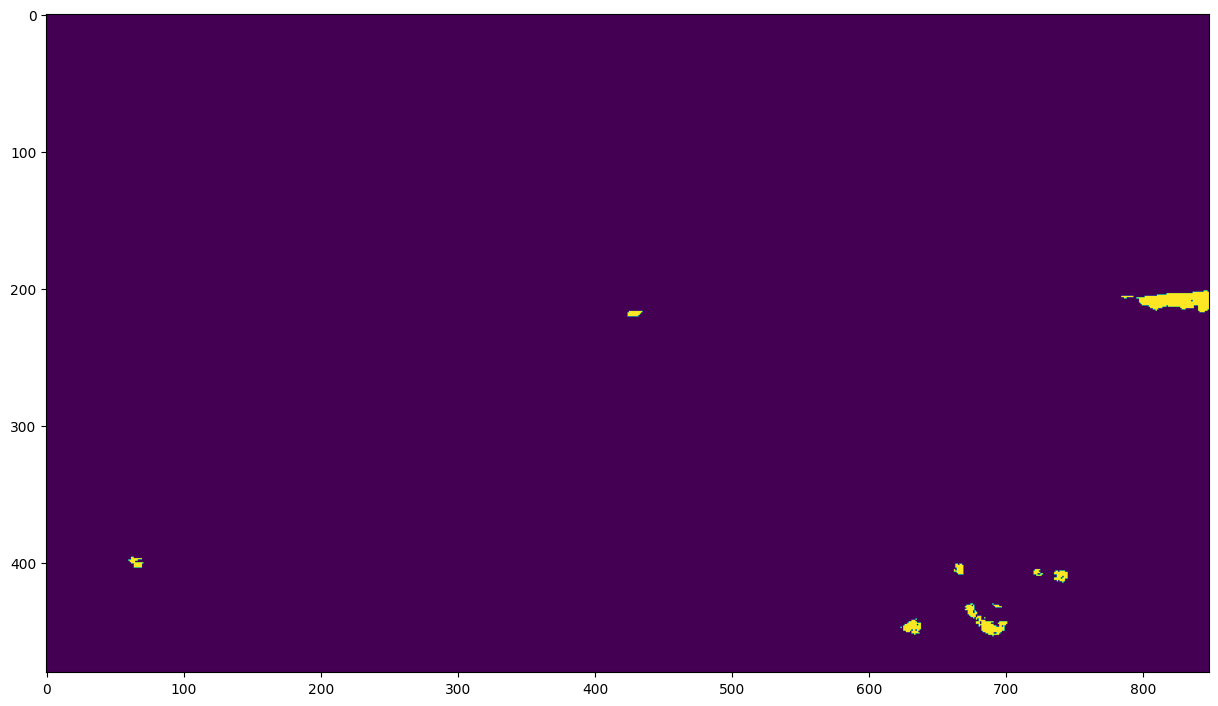

In [ ]:
error_matrix = difference_pic

# Find the unique values in the array
unique_values = np.unique(error_matrix)

# Sort the unique values in descending order and get the 10 largest ones
largest_values = np.sort(unique_values)[::-1][:1000]

# Create a Boolean mask that sets the largest 10 unique values to True
mask = np.isin(error_matrix, largest_values)

difference_pic_zero_extremes = np.zeros_like(error_matrix)
difference_pic_zero_extremes[mask] = 255


fig = plt.figure(figsize =(15, 15))
plt.imshow(difference_pic_zero_extremes)
plt.show()

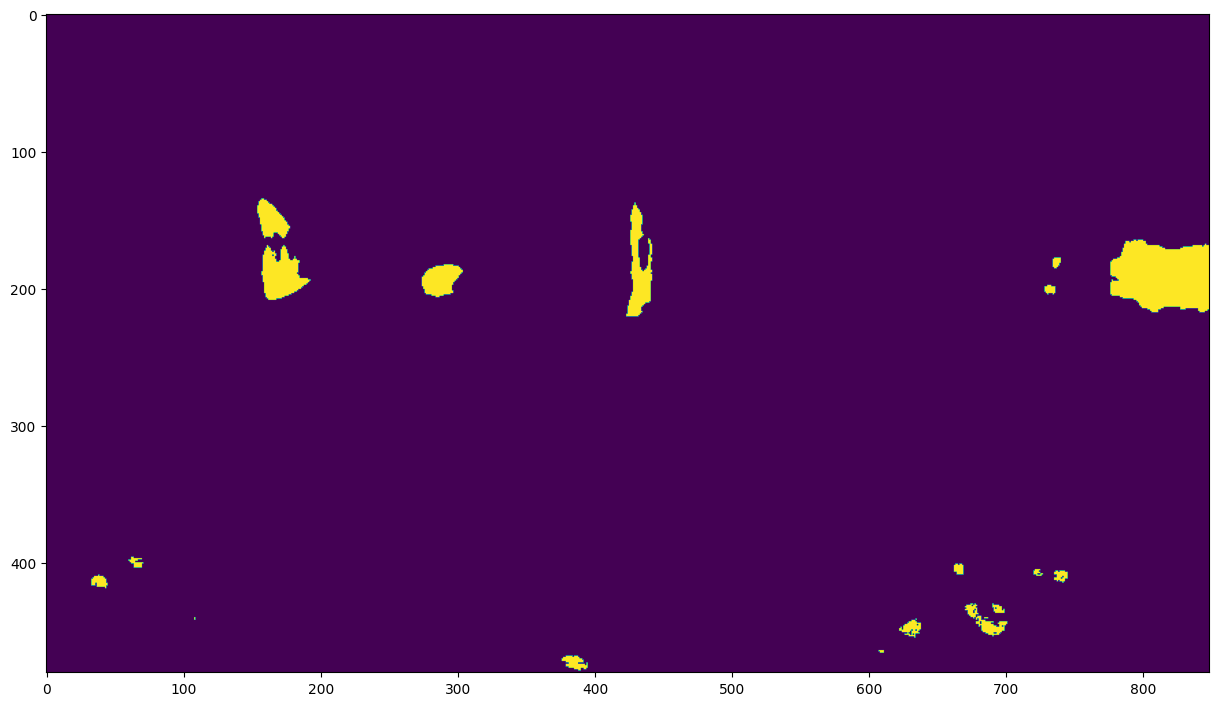

In [ ]:
error_matrix = difference_pic

# Find the unique values in the array
unique_values = np.unique(error_matrix)

# Sort the unique values in descending order and get the 10 largest ones
largest_values = np.sort(unique_values)[::-1][:3500]

# Create a Boolean mask that sets the largest 10 unique values to True
mask = np.isin(error_matrix, largest_values)

difference_pic_zero_extremes = np.zeros_like(error_matrix)
difference_pic_zero_extremes[mask] = 255


fig = plt.figure(figsize =(15, 15))
plt.imshow(difference_pic_zero_extremes)
plt.show()

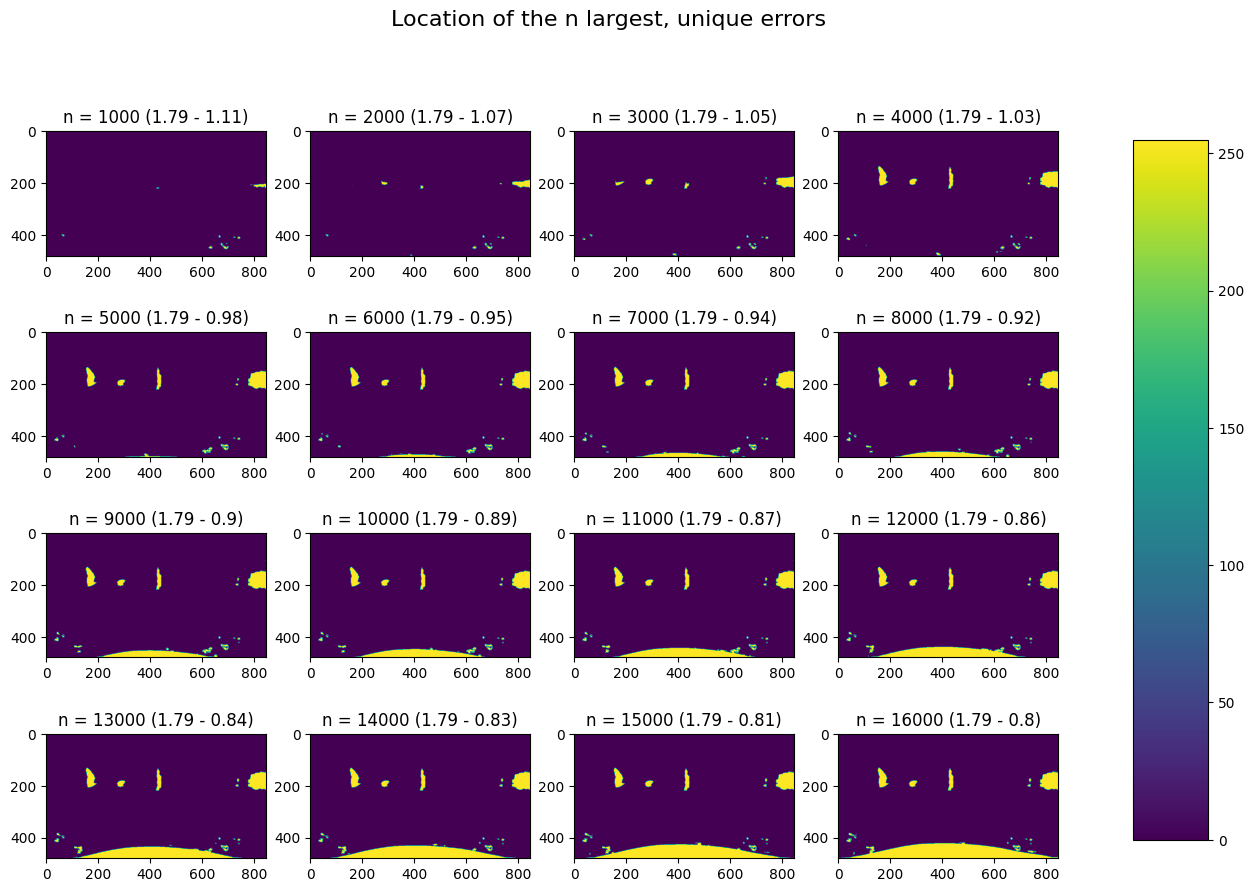

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize =(15, 10))
for idx, ax in enumerate(axes.flat):

    error_matrix = difference_pic

    # Find the unique values in the array
    unique_values = np.unique(error_matrix)

    # Sort the unique values in descending order and get the 'largest_amount' largest ones
    largest_amount = 1000*(idx+1)
    largest_values = np.sort(unique_values)[::-1][:(largest_amount)]

    # Create a Boolean mask that sets the largest 10 unique values to True
    mask = np.isin(error_matrix, largest_values)

    difference_pic_zero_extremes = np.zeros_like(error_matrix)
    difference_pic_zero_extremes[mask] = 255

    # fig = plt.figure(figsize =(15, 15))
    roundingval = 2
    text = "n = "+str(largest_amount) + " (" + str(round(largest_values[0],roundingval)) + " - " +str(round(largest_values[-1],roundingval)) + ")"
    ax.set_title(text)   
    
    im = ax.imshow(difference_pic_zero_extremes, vmin=0, vmax=255)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle('Location of the n largest, unique errors', fontsize=16)
plt.show()
# plt.colorbar(label="error", orientation="horizontal")


We can see the following:
* *HIGH MAGNITUDE ERRORS*: Very <ins>small artifacts</ins> in various places without obvious pattern 
* *MEDIUM MAGNITUDE ERRORS*: Larger areas of <ins>lower accuracy</ins> in the <ins>background</ins>
* *LOW MAGNITUDE ERRORS*: Tendency of errors in the <ins>foreground</ins>

# ToDo's
---
* Analyze Timing
    * get time of LEFT and RIGHT frames
* Second Performance Analysis
    * Add function that takes pictures with similar timestamp
    * Compare performance again

###  Finding the indices where the ground truth is best comparable with the depth estimation, because they have been taken at a similar time.

In [ ]:
bag = rosbag.Bag(os.path.join('drone_data', bag_file_name))

timestamps_cam1 = []
timestamps_cam2 = []

for msg in bag.read_messages(topics=[topic_cam1]):
    timestamps_cam1.append(msg.timestamp.to_sec())

for msg in bag.read_messages(topics=[topic_depth]):
    timestamps_cam2.append(msg.timestamp.to_sec())

In [ ]:
def find_indices(array1, array2, threshold):
    indices = []
    for i in range(len(array1)):
        for j in range(len(array2)):
            if abs(array1[i] - array2[j]) <= threshold:
                indices.append((i, j))
    return indices

# Example usage
array1 = np.array(timestamps_cam1)
array2 = np.array(timestamps_cam2)
threshold = 0.0001

indices = find_indices(array1, array2, threshold)
print(indices)

[(297, 266)]


In [ ]:
# d_timestamps = []

# for idx, timestamp in enumerate(timestamps[0:-1]): 
#     d_timestamps.append(timestamps_cam1[idx+1]-timestamps_cam1[idx])


In [ ]:
'''
We have:
    - depth_estimate_images         [0-65534 or 65535] ?! TODO: check this
    - depth_measurement_images      [0-65535] in mm // TODO: Check if actually mm (could also be value set in camera-options)
'''
# max_depth = depth_measurement_images[idx_analysed_frame].max()
# difference_pic_zero = depth_estimate_images[idx_analysed_frame]/255 + depth_measurement_images[idx_analysed_frame]/max_depth

max_measured_depth = data[test_run][model_type]['depth_rs'][297].max()
print('Maximum measured depth: ' + str(max_measured_depth))

max_estimated1_depth = data[test_run][model_type]['depth_estimate1'][266].max()
# max_estimated2_depth = data[test_run][model_type]['depth_estimate1'][idx_analysed_frame].max()
print('Maximum estimated depth: ' + str(max_estimated1_depth))



difference_pic = data[test_run][model_type]['depth_estimate1'][297]/max_estimated1_depth + data[test_run][model_type]['depth_rs'][266]/max_measured_depth
difference_pic.max()

Maximum measured depth: 65535
Maximum estimated depth: 65535


1.1209582665751125

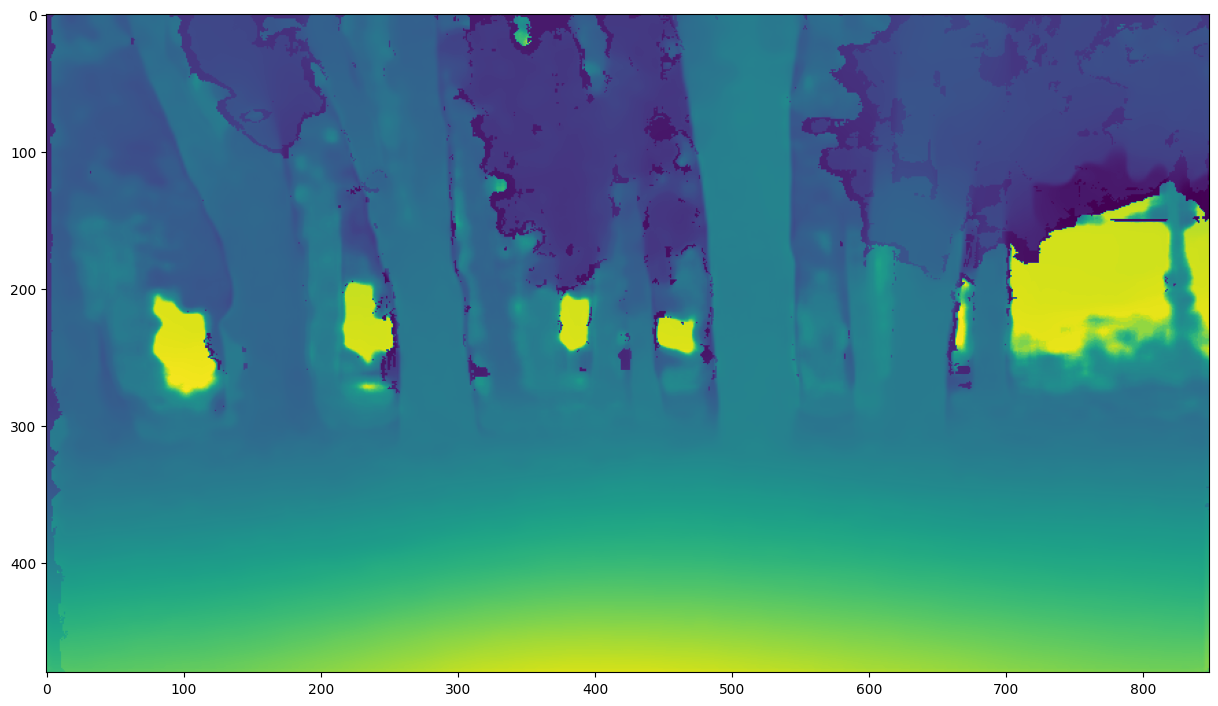

In [ ]:
fig = plt.figure(figsize =(15, 15))
plt.imshow(difference_pic) # cmap='gray'
plt.show()

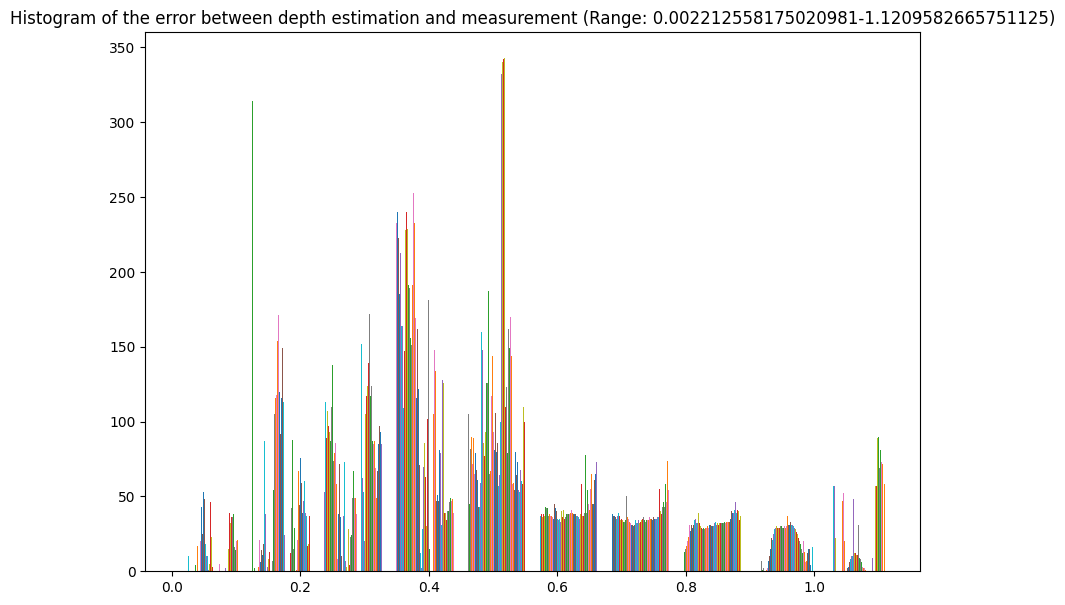

In [ ]:
fig = plt.figure(figsize =(10, 7))

plt.hist(difference_pic)   #, bins=10 

max_error = difference_pic.max()
min_error = difference_pic.min()
text="Histogram of the error between depth estimation and measurement (Range: " + str(min_error) + "-" + str(max_error) + ")"

plt.title(text)
plt.show()

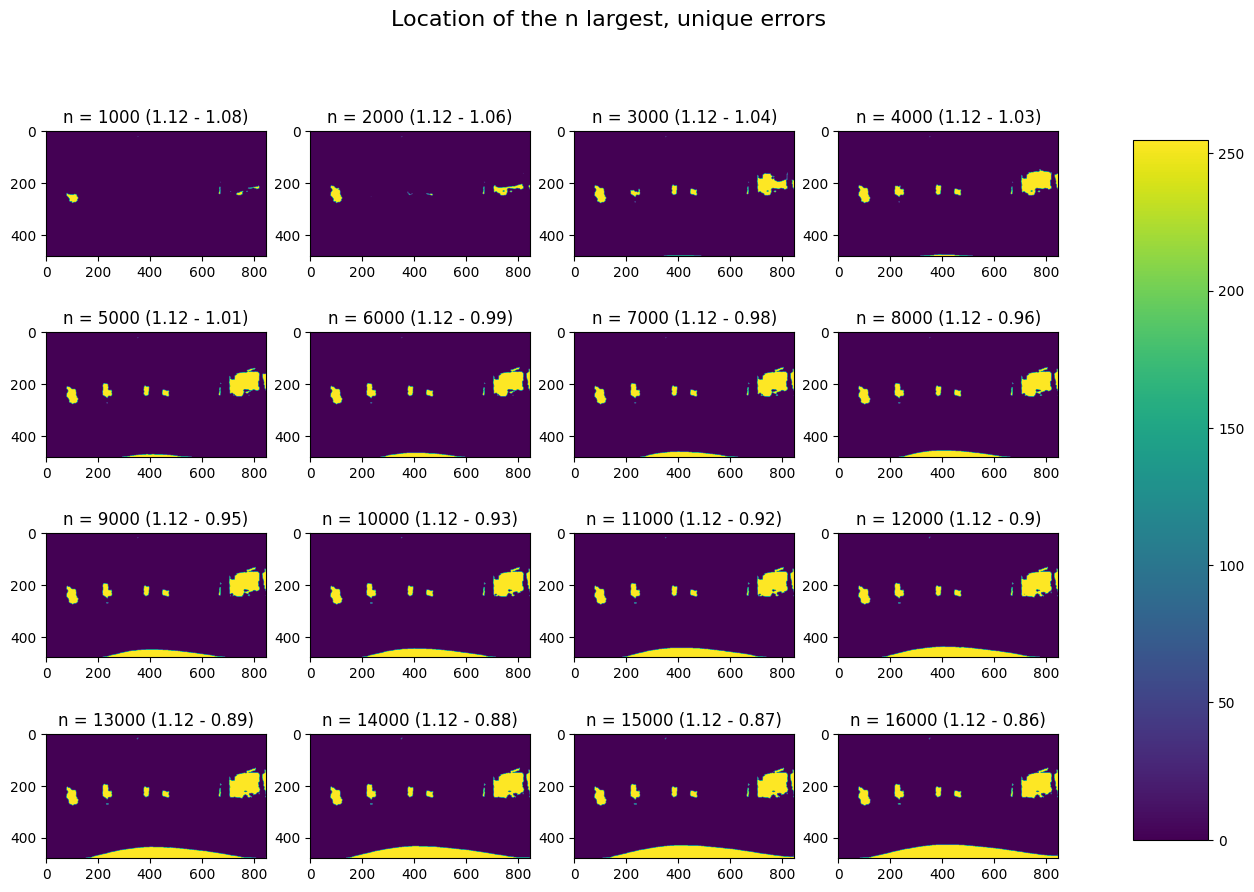

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize =(15, 10))
for idx, ax in enumerate(axes.flat):

    error_matrix = difference_pic

    # Find the unique values in the array
    unique_values = np.unique(error_matrix)

    # Sort the unique values in descending order and get the 'largest_amount' largest ones
    largest_amount = 1000*(idx+1)
    largest_values = np.sort(unique_values)[::-1][:(largest_amount)]

    # Create a Boolean mask that sets the largest 10 unique values to True
    mask = np.isin(error_matrix, largest_values)

    difference_pic_zero_extremes = np.zeros_like(error_matrix)
    difference_pic_zero_extremes[mask] = 255

    # fig = plt.figure(figsize =(15, 15))
    roundingval = 2
    text = "n = "+str(largest_amount) + " (" + str(round(largest_values[0],roundingval)) + " - " +str(round(largest_values[-1],roundingval)) + ")"
    ax.set_title(text)   
    
    im = ax.imshow(difference_pic_zero_extremes, vmin=0, vmax=255)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle('Location of the n largest, unique errors', fontsize=16)
plt.show()
# plt.colorbar(label="error", orientation="horizontal")

It is obvious that the step of only considering data from similar points in time is smart.